In [5]:
%pip install networkx

In [6]:
%pip install psycopg2-binary


Note: you may need to restart the kernel to use updated packages.


In [7]:
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [8]:
%pip install pandas

Note: you may need to restart the kernel to use updated packages.


In [2]:
import networkx as nx

In [3]:
import matplotlib.pyplot as plt

In [4]:
import psycopg2

In [5]:
import pandas as pd

In [6]:
DB_NAME = 'mapData'
DB_USER = 'postgres'
DB_PASSWORD = '1234'
DB_HOST = 'localhost'

In [7]:
# Establish a connection to the database
conn = psycopg2.connect(dbname=DB_NAME, user=DB_USER, password=DB_PASSWORD, host=DB_HOST)

In [8]:
# Create a cursor object to execute SQL queries
cur = conn.cursor()

In [9]:
# Fetch data from table
cur.execute('SELECT * FROM edges_lrt_mrt')
rows = cur.fetchall()

In [10]:
# Fetch crowd_status data from table merged_mrt_lrt
cur.execute('SELECT * FROM merged_mrt_lrt')
rows_crowd = cur.fetchall()

In [37]:

# Convert the fetched data into a pandas DataFrame
columns = ['id', 'line', 'station_name', 'latitude', 'longitude', 'crowd_status', 'availibility_status', 'order_index']
df = pd.DataFrame(rows_crowd, columns=columns)

# Select only the 'id', 'station_name', and 'crowd_status' columns
df_selected = df[['id', 'station_name', 'crowd_status']]

# Display the DataFrame
print(df_selected)


      id              station_name        crowd_status
0     44             Bandar Puteri        Not too busy
1    136  Tun Razak Exchange (TRX)  As busy as it gets
2     33      Bandar Tasik Selatan       A little busy
3     34               Sungai Besi       A little busy
4     35               Bukit Jalil       A little busy
..   ...                       ...                 ...
155   95                Sri Delima        Not too busy
156   97                  Kentomen       A little busy
157   98                Jalan Ipoh            Not busy
158   99              Sentul Barat       A little busy
159   96              Kampung Batu       A little busy

[160 rows x 3 columns]


In [12]:
# Convert the fetched data into a pandas DataFrame for easier manipulation
columns = ['id','source_station_id', 'destination_station_id', 'distance']
df = pd.DataFrame(rows, columns=columns)

In [13]:
cur.close()
conn.close()

In [14]:
# Display the fetched data
print(df)

      id  source_station_id  destination_station_id  distance
0    309                  1                       2         3
1    310                  2                       3         2
2    311                  3                       4         3
3    312                  4                       5         3
4    313                  5                       6         3
..   ...                ...                     ...       ...
179  488                 84                      47         1
180  489                  5                     160        10
181  490                  9                     155         2
182  491                155                      27         2
183  492                  9                      27         0

[184 rows x 4 columns]


In [15]:
import networkx as nx

In [16]:
# Create an empty graph
G = nx.Graph()

In [17]:
# Add edges representing connections between stations
for index, row in df.iterrows():
    G.add_edge(row['source_station_id'], row['destination_station_id'], weight=row['distance'])


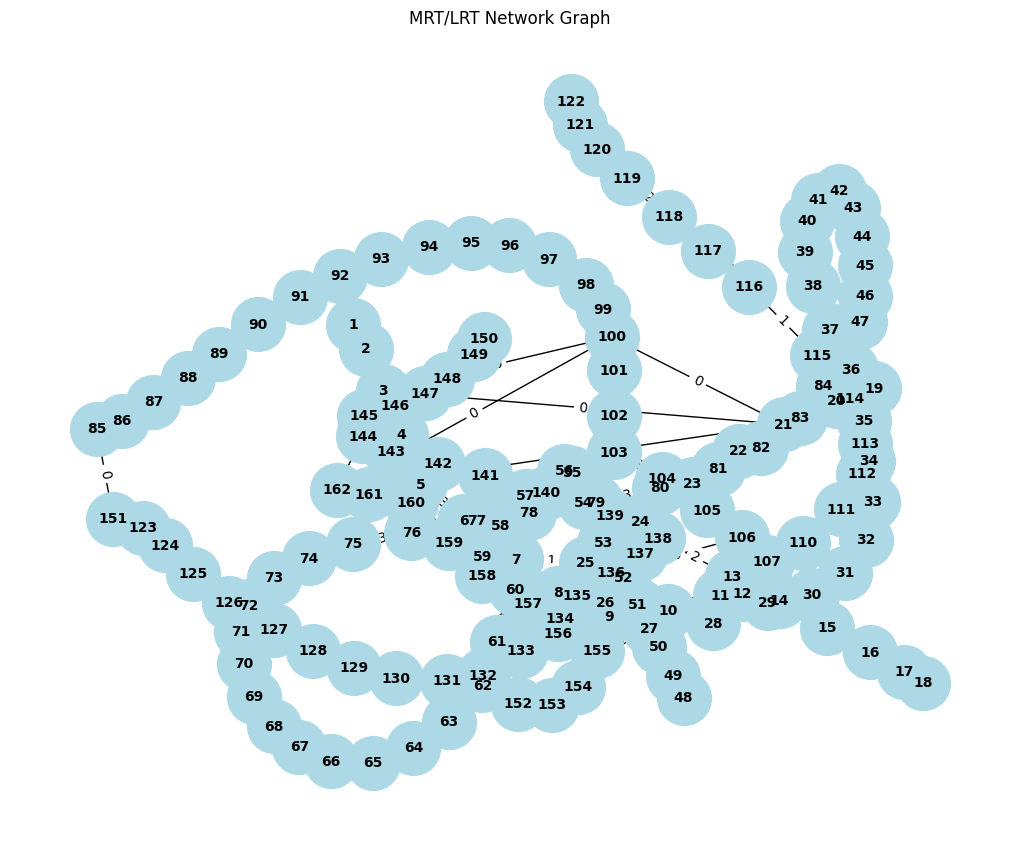

In [18]:
# Draw the graph
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_size=1500, node_color='lightblue', font_size=10, font_weight='bold', arrows=True)
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
plt.title('MRT/LRT Network Graph')
plt.show()

In [31]:
import heapq
import math

def astar_shortest_path(G, source_station_id, destination_station_id, avoid_crowd=False):
    path = None
    def heuristic_distance(source_station_id, destination_station_id):
        source_x, source_y = pos[source_station_id]
        destination_x, destination_y = pos[destination_station_id]
        distance = abs(destination_x - source_x) + abs(destination_y - source_y)
        return distance
    
    # Define the priority queue for the open set
    open_set = [(0, source_station_id)]
    # Define the set of visited stations
    visited = set()
    # Define the dictionary to store the actual distance from the start station to each station
    g_score = {source_station_id: 0}
    # Define the dictionary to store the estimated total distance from the start station to each station
    f_score = {source_station_id: heuristic_distance(source_station_id, destination_station_id)}
    # Define the dictionary to store the previous station in the shortest path
    came_from = {}
    
    while open_set:
        # Get the station with the lowest f_score
        _, current_station = heapq.heappop(open_set)
        
        if current_station == destination_station_id:
            # Reconstruct the path from the end station to the start station
            path = [current_station]
            while current_station != source_station_id:
                current_station = came_from[current_station]
                path.append(current_station)
            path.reverse()
            return path
        
        # Add the current station to the visited set
        visited.add(current_station)
        
        # Explore the neighbors of the current station
        for neighbor in G.neighbors(current_station):
            if neighbor in visited:
                continue

            # Ignore the avoidance if the neighbor is the destination station or start station
            if avoid_crowd and neighbor in [source_station_id, destination_station_id]:
                continue
            
            # Check if the neighbor station is busy and should be avoided
            if avoid_crowd and neighbor in df_selected[df_selected['crowd_status'].isin(['As busy as it gets', 'Busier than usual'])]['id'].values:
                continue

            # Calculate the tentative g_score for the neighbor
            tentative_g_score = g_score[current_station] + G[current_station][neighbor]['weight']
            
            if neighbor not in g_score or tentative_g_score < g_score[neighbor]:
                # Update the g_score and f_score for the neighbor
                g_score[neighbor] = tentative_g_score
                f_score[neighbor] = g_score[neighbor] + heuristic_distance(neighbor, destination_station_id)
                # Update the came_from dictionary
                came_from[neighbor] = current_station
                # Add the neighbor to the open set
                heapq.heappush(open_set, (f_score[neighbor], neighbor))

    # If no path is found and avoid_crowd is True, try again without avoiding crowded stations
    if path is None and avoid_crowd:
        print("No path found avoiding crowded stations. Finding path without avoiding crowded stations...")
        return astar_shortest_path(G, source_station_id, destination_station_id, avoid_crowd=False)

    # If no path is found and avoid_crowd is False, return an empty list
    return path if path is not None else []




In [46]:
# Create a dictionary mapping station names to IDs
station_name_to_id = df_selected.set_index(df_selected['station_name'].str.lower())['id'].to_dict()

In [51]:
# Prompt the user for input
source_station_name = input("Enter the start station name: ").lower()
destination_station_name = input("Enter the end station name: ").lower()
avoid_crowd = input("Avoid crowded stations? (y/n): ").lower() == "y"

# Convert station names to IDs
source_station_id = station_name_to_id[source_station_name]
destination_station_id = station_name_to_id[destination_station_name]

# Call the function with user input
path = astar_shortest_path(G, source_station_id, destination_station_id, avoid_crowd)

# Get the list of crowded stations
crowded_stations = df_selected[df_selected['crowd_status'].isin(['As busy as it gets', 'Busier than usual'])]['id'].values

# Create a new path list with crowd status for crowded stations
path_with_crowd_status = []
for station in path:
    if station in crowded_stations:
        crowd_status = df_selected[df_selected['id'] == station]['crowd_status'].values[0]
        station_name = df_selected[df_selected['id'] == station]['station_name'].values[0]
        path_with_crowd_status.append(f"{station_name} ({crowd_status})")
    else:
        station_name = df_selected[df_selected['id'] == station]['station_name'].values[0]
        path_with_crowd_status.append(str(station_name))

print("Shortest path:", path_with_crowd_status)

No path found avoiding crowded stations. Finding path without avoiding crowded stations...
Shortest path: ['Damansara Damai', 'Sri Damansara Barat', 'Sri Damansara Sentral (Busier than usual)', 'Sri Damansara Timur', 'Metro Prima (Busier than usual)', 'Kepong Baru', 'Jinjang', 'Sri Delima', 'Kampung Batu', 'Kentomen', 'Jalan Ipoh', 'Sentul Barat', 'Titiwangsa', 'Titiwangsa', 'Chow Kit', 'Medan Tuanku', 'Bukit Nanas', 'Raja Chulan', 'Bukit Bintang']
